In [101]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel 
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data 
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import random
import os
from PIL import Image

Exemplo: https://www.kaggle.com/code/ankit7bisht/fork-of-dcgan-150940

Dataset: https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256

# Iniciando a SEED e os Hiperparametros

In [102]:
seed = 500
random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# Local de salvamento das imagens
dataroot = r'./celeba_hq_256'

#number of workers for dataloader
workers = 2

#Tamanho do batch de treinamento
batch_size = 256

# tamanho de treinamento das imagens
image_size = 64

#Canais de cor (RGB)
nc =3

nz=200
# Tamanho do mapa das features do gerador
ngf = 64

# Tamanho do mapa das features do discriminador
ndf = 64

# Numero de epocas do treinamento inicial 
num_epochs = 150
beta1 = 0.5
ngpu=1



In [104]:
# criando o dataset das imagens
dataset = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
)

In [ ]:
# Carregando os dados do Dataset
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

In [ ]:
# Preprando o dispositivo para o treinamento da rede
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu>0) else 'cpu')

In [ ]:
# Carregando o lote dos dados de treinamento
real_batch = next(iter(dataloader))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000227B97E5260>
Traceback (most recent call last):
  File "c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\multiprocessing\popen_spawn_win32.py", line 112, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


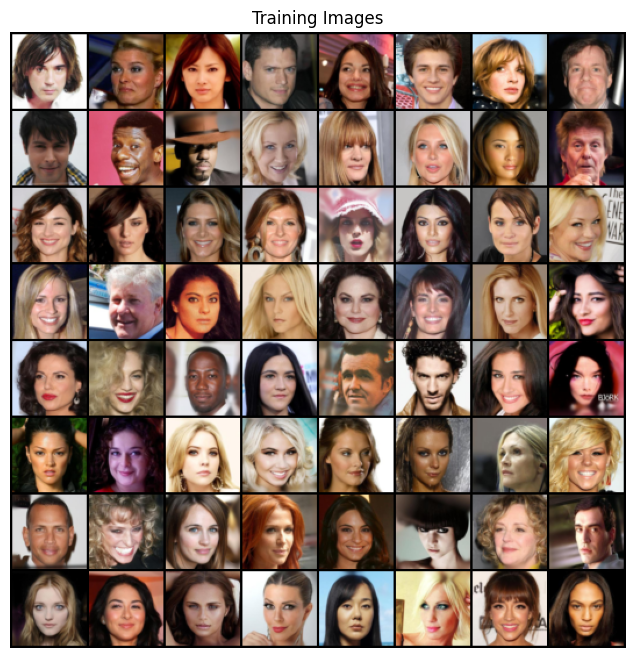

In [ ]:
# Gerando o primeiro plot para verificar se as imagens foram importadas corretamente 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], 
            padding=2, 
            normalize=True).cpu(),(1,2,0)))

# Contruindo a arquitetura da DCGANS

In [ ]:
# criando a função de inicialização dos pesos para o treinametno da rede
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0,0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Criando a classe do gerador, para ser treinado

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # Ajustando tamanho para (ngf*8) 4x4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4,2,1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # Ajustando tamanho para (ngf*4) 8x8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4,2,1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # Ajustando tamanho para (ngf*2) 16x16
            nn.ConvTranspose2d(ngf*2, ngf, 4,2,1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Ajustando tamanho para (ngf) 32x32
            nn.ConvTranspose2d(ngf,nc, 4,2,1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Criando o gerador
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu>1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Aplicando função weights_init para iniciar de maneira randomica os pesos 
# média =0, stdev=0.2

netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
# Criando a classe do discriminador, para ser treinado
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# Criando o Discriminador
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu>1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Aplicando weights_init para iniciar o pesos aleatoriamente
# média = 0, stdev=.2
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Iniciando a primeira versão de treinamento

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()


fixed_noise = torch.randn(64, nz, 1,1,device=device)

real_label = 1
fake_label = 0
lr_D = 0.0001
lr_G = 0.0003
optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

In [ ]:
# Lista para acomparnhar o progresso
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Atualização do discriminador: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Treinando com todas as batchs
        netD.zero_grad()
        # Formatando a batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,dtype=torch.float, device=device)
        # Propagação direta do batch real através do discriminador
        output = netD(real_cpu).view(-1)
        # Calculando a função de loss para todos os lotes
        errD_real = criterion(output, label)
        # Calculando o gradiente para o discriminador durante a retropropagação
        errD_real.backward()
        D_x = output.mean().item()

        ## Treinando com os lotes falsos
        # Criando um lote de vetores latentes 
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Gerando lote de imagens falsas com o gerador
        fake = netG(noise)
        label.fill_(fake_label)
        # Utilizando o Discriminador para classificar as imagens geradas
        output = netD(fake.detach()).view(-1)
        # Calculando a perda de D's para todos os lotes
        errD_fake = criterion(output, label)
        # Calculando o gradiente para este lote 
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Acumulando o gradiente do lote das imagens reais e das falsas
        errD = errD_real + errD_fake
        # Atualizando D
        optimizerD.step()

        ############################
        # (2) Atualiazando o Gerador: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Considerando os rotulos falsos como real para o calculo do custo do gerador
        # Uma vez atualizado o discriminador, será realizada uma nov passagem do lote de imagens falsas através dele
        output = netD(fake).view(-1)
        # Calculando a perda do gerador baseado no saida do discriminador de imagens falsas 
        errG = criterion(output, label)
        # Calculando o novo gradiente do gerador
        errG.backward()
        D_G_z2 = output.mean().item()
        # Atualizando o gerador
        optimizerG.step()

        # printando as estatisticas do treinamento
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Salvando os dados das perdas
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Verificando como o gerador esta se saindo e a partir do vetor de ruido fixo
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/150][0/118]	Loss_D: 1.9779	Loss_G: 2.6765	D(x): 0.7015	D(G(z)): 0.7221 / 0.1027
[1/150][0/118]	Loss_D: 0.9018	Loss_G: 6.3317	D(x): 0.7966	D(G(z)): 0.3179 / 0.0021
[2/150][0/118]	Loss_D: 1.4479	Loss_G: 1.2047	D(x): 0.4656	D(G(z)): 0.2973 / 0.3298
[3/150][0/118]	Loss_D: 1.2927	Loss_G: 2.6714	D(x): 0.7469	D(G(z)): 0.5778 / 0.0956
[4/150][0/118]	Loss_D: 1.0235	Loss_G: 1.7521	D(x): 0.5398	D(G(z)): 0.2303 / 0.2248
[5/150][0/118]	Loss_D: 1.4114	Loss_G: 3.5281	D(x): 0.8326	D(G(z)): 0.6539 / 0.0464
[6/150][0/118]	Loss_D: 1.1111	Loss_G: 2.2233	D(x): 0.6879	D(G(z)): 0.4688 / 0.1430
[7/150][0/118]	Loss_D: 1.2990	Loss_G: 1.1550	D(x): 0.4915	D(G(z)): 0.3494 / 0.3510
[8/150][0/118]	Loss_D: 1.3490	Loss_G: 2.5871	D(x): 0.7322	D(G(z)): 0.5907 / 0.0992
[9/150][0/118]	Loss_D: 1.4237	Loss_G: 2.1028	D(x): 0.6787	D(G(z)): 0.5816 / 0.1582
[10/150][0/118]	Loss_D: 1.2109	Loss_G: 2.0078	D(x): 0.6563	D(G(z)): 0.4879 / 0.1652
[11/150][0/118]	Loss_D: 1.3825	Loss_G: 1.1553	D(x): 0.4613	D

In [ ]:
# Salvando o gerador e o discriminador
caminho_pasta = './models/gans'
#os.makedirs(caminho_pasta)

caminho_generator = os.path.join(caminho_pasta, 'generator.pth')
caminho_discriminator = os.path.join(caminho_pasta, 'discriminator.pth')

torch.save(netG.state_dict(), caminho_generator)
torch.save(netD.state_dict(), caminho_discriminator)


In [ ]:
# Salvando todas as estatisticas do modelo
torch.save({
    'epoch': epoch,
    'netG_state_dict': netG.state_dict(),
    'netD_state_dict': netD.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
    'G_losses': G_losses,
    'D_losses': D_losses,
    'fixed_noise': fixed_noise,
    'iters': iters
}, os.path.join(caminho_pasta, 'dcgan_checkpoint.pth'))

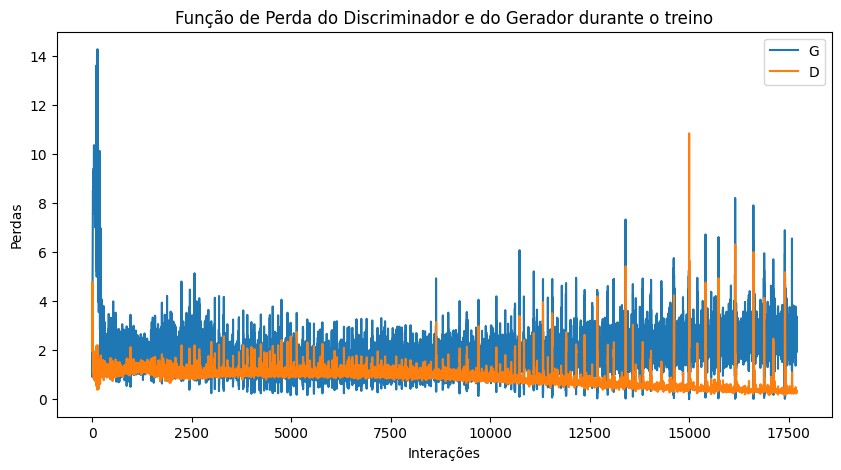

In [99]:
#Plotando as funções de perda do discriminador e do gerador
plt.figure(figsize=(10,5))
plt.title("Função de Perda do Discriminador e do Gerador durante o treino")
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('Interações')
plt.ylabel('Perdas')
plt.legend()
plt.show()


In [ ]:
# Salvando imagem gerada randomicamente 
noise = torch.randn(1, nz, 1, 1, device=device)
with torch.no_grad():
    fake = netG(noise).detach().cpu()
    vutils.save_image(fake, f'./imagens_falsas/imagem_gerada_teste.png', normalize=True)

In [ ]:
# Gerando diversas imagens
fake_batch = []
for i in range(0,300):
    # Gerar ruído aleatório
    noise = torch.randn(1, nz, 1, 1, device=device)
    with torch.no_grad():
        fake = netG(noise).detach().cpu()
        vutils.save_image(fake, f'./imagens_falsas/imagem_gerada{i}.png', normalize=True)

# Segundo Treinamento

### Objetivo
Melhorar o Gerador a partir da inserção de mais épocas de treinamento

In [ ]:
# 1. Recriando os modelos
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

# 2. Recriando os modelos com os mesmos hiperparametros
lr_D = 0.0001
lr_G = 0.0003
beta1 = 0.5  


optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

# 3. Carregando o checkpoint
checkpoint = torch.load(r"C:\Users\maria\Documents\Rodrigo\models\gans\V2 - 150 epochs\dcgan_checkpoint.pth")

netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])

# 4. Carregando os otimizadors
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

# 5. Continuando a partir da ultima epoch
start_epoch = checkpoint['epoch'] + 1

In [ ]:
# Lista para acomparnhar o progresso
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 200

print("Starting Training Loop...")
for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Atualização do discriminador: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Treinando com todas as batchs
        netD.zero_grad()
        # Formatando a batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,dtype=torch.float, device=device)
        # Propagação direta do batch real através do discriminador
        output = netD(real_cpu).view(-1)
        # Calculando a função de loss para todos os lotes
        errD_real = criterion(output, label)
        # Calculando o gradiente para o discriminador durante a retropropagação
        errD_real.backward()
        D_x = output.mean().item()

        ## Treinando com os lotes falsos
        # Criando um lote de vetores latentes 
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Gerando lote de imagens falsas com o gerador
        fake = netG(noise)
        label.fill_(fake_label)
        # Utilizando o Discriminador para classificar as imagens geradas
        output = netD(fake.detach()).view(-1)
        # Calculando a perda de D's para todos os lotes
        errD_fake = criterion(output, label)
        # Calculando o gradiente para este lote 
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Acumulando o gradiente do lote das imagens reais e das falsas
        errD = errD_real + errD_fake
        # Atualizando D
        optimizerD.step()

        ############################
        # (2) Atualiazando o Gerador: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Considerando os rotulos falsos como real para o calculo do custo do gerador
        # Uma vez atualizado o discriminador, será realizada uma nov passagem do lote de imagens falsas através dele
        output = netD(fake).view(-1)
        # Calculando a perda do gerador baseado no saida do discriminador de imagens falsas 
        errG = criterion(output, label)
        # Calculando o novo gradiente do gerador
        errG.backward()
        D_G_z2 = output.mean().item()
        # Atualizando o gerador
        optimizerG.step()

        # printando as estatisticas do treinamento
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Salvando os dados das perdas
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Verificando como o gerador esta se saindo e a partir do vetor de ruido fixo
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

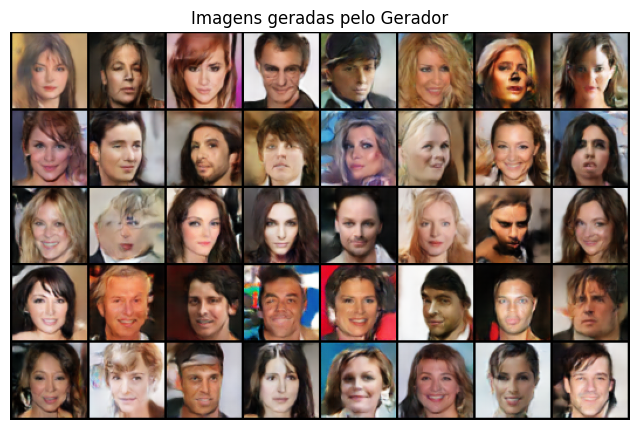

In [123]:
with torch.no_grad():
    fake = netG(noise).detach().cpu()
    grid = vutils.make_grid(fake, normalize=True)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Imagens geradas pelo Gerador")
plt.imshow(grid.permute(1, 2, 0))  # converte de CHW para HWC
plt.show()

In [125]:
noise = torch.randn(1, nz, 1, 1, device=device)
with torch.no_grad():
    fake = netG(noise).detach().cpu()
    vutils.save_image(fake, f'./imagens_falsas_v2/imagem_gerada_teste.png', normalize=True)

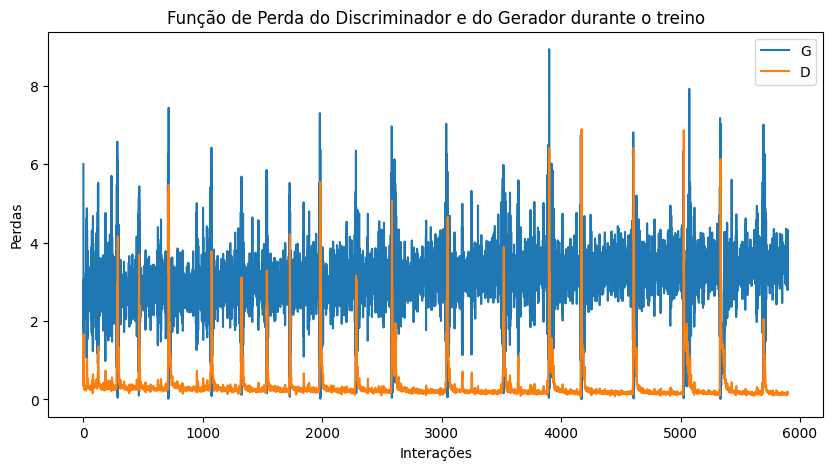

In [129]:
#Plotando as funções de perda do discriminador e do gerador
plt.figure(figsize=(10,5))
plt.title("Função de Perda do Discriminador e do Gerador durante o treino")
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('Interações')
plt.ylabel('Perdas')
plt.legend()
plt.show()


In [127]:
torch.save({
    'epoch': epoch,
    'netG_state_dict': netG.state_dict(),
    'netD_state_dict': netD.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
    'G_losses': G_losses,
    'D_losses': D_losses,
    'fixed_noise': fixed_noise,
    'iters': iters
}, os.path.join(caminho_pasta, 'dcgan_checkpoint.pth'))

# V3 treinando com learning Rate mais lento

In [151]:
# 1. Recrie os modelos exatamente como antes
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

# 2. Recrie os otimizadores com os mesmos hiperparâmetros
lr_D = 0.00005
lr_G = 0.0002
beta1 = 0.5  # Certifique-se que o beta1 é o mesmo do treino original

# 3. Carregue o checkpoint
checkpointD = torch.load(r"C:\Users\maria\Documents\Rodrigo\models\gans\V2 - 150 epochs\discriminator.pth")
checkpointG = torch.load(r"C:\Users\maria\Documents\Rodrigo\models\gans\V2 - 150 epochs\generator.pth")

netG.load_state_dict(checkpointG)
netD.load_state_dict(checkpointD)

optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))


In [ ]:
num_epochs = 200


print("Starting Training Loop...")
for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Atualização do discriminador: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Treinando com todas as batchs
        netD.zero_grad()
        # Formatando a batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,dtype=torch.float, device=device)
        # Propagação direta do batch real através do discriminador
        output = netD(real_cpu).view(-1)
        # Calculando a função de loss para todos os lotes
        errD_real = criterion(output, label)
        # Calculando o gradiente para o discriminador durante a retropropagação
        errD_real.backward()
        D_x = output.mean().item()

        ## Treinando com os lotes falsos
        # Criando um lote de vetores latentes 
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Gerando lote de imagens falsas com o gerador
        fake = netG(noise)
        label.fill_(fake_label)
        # Utilizando o Discriminador para classificar as imagens geradas
        output = netD(fake.detach()).view(-1)
        # Calculando a perda de D's para todos os lotes
        errD_fake = criterion(output, label)
        # Calculando o gradiente para este lote 
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Acumulando o gradiente do lote das imagens reais e das falsas
        errD = errD_real + errD_fake
        # Atualizando D
        optimizerD.step()

        ############################
        # (2) Atualiazando o Gerador: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Considerando os rotulos falsos como real para o calculo do custo do gerador
        # Uma vez atualizado o discriminador, será realizada uma nov passagem do lote de imagens falsas através dele
        output = netD(fake).view(-1)
        # Calculando a perda do gerador baseado no saida do discriminador de imagens falsas 
        errG = criterion(output, label)
        # Calculando o novo gradiente do gerador
        errG.backward()
        D_G_z2 = output.mean().item()
        # Atualizando o gerador
        optimizerG.step()

        # printando as estatisticas do treinamento
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Salvando os dados das perdas
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Verificando como o gerador esta se saindo e a partir do vetor de ruido fixo
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    if epoch % 50 == 0:
        caminho = os.path.join(r'C:\Users\maria\Documents\Rodrigo\models\gans', f'checkpoint_{epoch}')
        os.makedirs(caminho)
        torch.save({
            'epoch': epoch,
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'G_losses': G_losses,
            'D_losses': D_losses,
            'fixed_noise': fixed_noise,
            'iters': iters
        }, os.path.join(caminho_pasta, os.path.join(caminho, 'dcgan_checkpoint.pth'))
        )

caminho = os.path.join(r'C:\Users\maria\Documents\Rodrigo\models\gans', f'checkpoint_200')
os.makedirs(caminho)
torch.save({
    'epoch': epoch,
    'netG_state_dict': netG.state_dict(),
    'netD_state_dict': netD.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
    'G_losses': G_losses,
    'D_losses': D_losses,
    'fixed_noise': fixed_noise,
    'iters': iters
}, os.path.join(caminho_pasta, os.path.join(caminho, 'dcgan_checkpoint.pth'))
)
        

Iniciando o treinamento
[0/200][0/118]	Loss_D: 0.3359	Loss_G: 4.0988	D(x): 0.9286	D(G(z)): 0.2142 / 0.0233
[1/200][0/118]	Loss_D: 0.2698	Loss_G: 2.8976	D(x): 0.9156	D(G(z)): 0.1539 / 0.0764
[2/200][0/118]	Loss_D: 0.2660	Loss_G: 3.1518	D(x): 0.9105	D(G(z)): 0.1474 / 0.0614
[3/200][0/118]	Loss_D: 0.2647	Loss_G: 3.1139	D(x): 0.8899	D(G(z)): 0.1270 / 0.0652
[4/200][0/118]	Loss_D: 0.2237	Loss_G: 3.6750	D(x): 0.9582	D(G(z)): 0.1556 / 0.0367
[5/200][0/118]	Loss_D: 0.2324	Loss_G: 3.5255	D(x): 0.9090	D(G(z)): 0.1188 / 0.0437
[6/200][0/118]	Loss_D: 0.2387	Loss_G: 2.9259	D(x): 0.8917	D(G(z)): 0.1089 / 0.0793
[7/200][0/118]	Loss_D: 0.2206	Loss_G: 2.7881	D(x): 0.9180	D(G(z)): 0.1185 / 0.0885
[8/200][0/118]	Loss_D: 0.2224	Loss_G: 3.1519	D(x): 0.9093	D(G(z)): 0.1104 / 0.0675
[9/200][0/118]	Loss_D: 0.1969	Loss_G: 3.4656	D(x): 0.9362	D(G(z)): 0.1158 / 0.0468
[10/200][0/118]	Loss_D: 0.1892	Loss_G: 3.3258	D(x): 0.8723	D(G(z)): 0.0469 / 0.0571
[11/200][0/118]	Loss_D: 0.3536	Loss_G: 1.3518	D(x): 0.7513	D(G

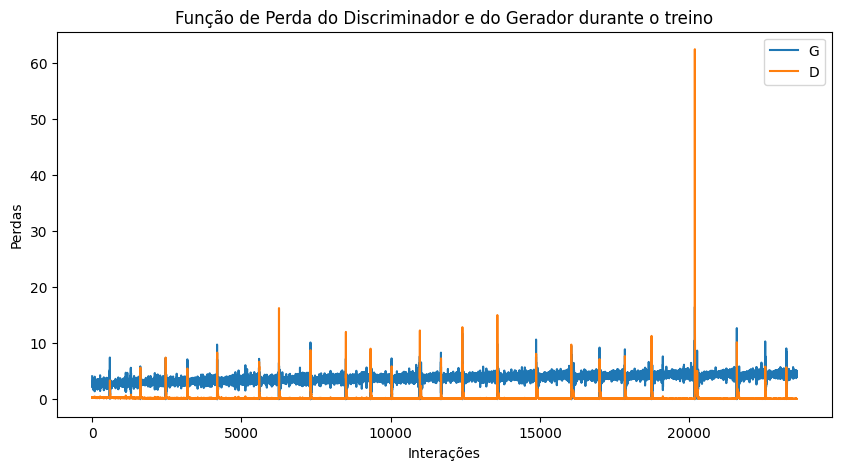

In [153]:
#Plotando as funções de perda do discriminador e do gerador
plt.figure(figsize=(10,5))
plt.title("Função de Perda do Discriminador e do Gerador durante o treino")
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('Interações')
plt.ylabel('Perdas')
plt.legend()
plt.show()

In [155]:
for i in range(0,300):
    noise = torch.randn(1, nz, 1, 1, device=device)
    with torch.no_grad():
        fake = netG(noise).detach().cpu()
        vutils.save_image(fake, f'./imagens_falsas_v3/imagem_gerada_teste_{i}.png', normalize=True)